### **IMPORTING LIBRARIES**

In [1]:
#Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
from datetime import timedelta
import random
warnings.filterwarnings("ignore")

### **DATA PREPROCESSING**

In [2]:
#Importing the Dataset
dataset = pd.read_csv('1804105.csv')
df = dataset.copy()

In [3]:
#Observing columns with unique and constant values
df.nunique()

business_code                 6
cust_number                1447
name_customer              4291
clear_date                  394
buisness_year                 2
doc_id                    50000
posting_date                501
document_create_date        506
document_create_date.1      502
due_in_date                 540
invoice_currency              2
document type                 2
posting_id                    1
area_business                 0
total_open_amount         45177
baseline_create_date        504
cust_payment_terms           67
invoice_id                49994
isOpen                        2
dtype: int64

1) Doc_id has unique values
2) Invoice_id has almost unique values
3) Area_Business has all null values
4) Posting Id has only value

In [4]:
#Observing frequency distribution of isOpen
df.isOpen.value_counts()

0    45576
1     4424
Name: isOpen, dtype: int64

In [5]:
#Dropping these columns coz these contain noise like constant, unique values or not useful etc
df.drop(columns=['area_business','posting_id','doc_id', 'document_create_date', 'invoice_id', 'isOpen'], axis = 1, inplace = True)

We dropped document create date because we will only consider document create date.1 as it is in a normalized way

In [6]:
#Observing NULL values
df.isna().sum()

business_code                0
cust_number                  0
name_customer                0
clear_date                4424
buisness_year                0
posting_date                 0
document_create_date.1       0
due_in_date                  0
invoice_currency             0
document type                0
total_open_amount            0
baseline_create_date         0
cust_payment_terms           0
dtype: int64

In [7]:
#Storing rows with null values in clear date in another dataframe, we will play with these later.
X_missing = df[df['clear_date'].isnull()].copy()
missing_clear_date = df[df['clear_date'].isnull()].copy()

In [8]:
#Dropping the rows with Null values present in clear_date. These are the rows which are still open and yet to be paid
df.dropna(subset=['clear_date'], inplace = True)

In [9]:
#Observing the datatypes of all columns
df.dtypes

business_code              object
cust_number                object
name_customer              object
clear_date                 object
buisness_year             float64
posting_date               object
document_create_date.1      int64
due_in_date               float64
invoice_currency           object
document type              object
total_open_amount         float64
baseline_create_date      float64
cust_payment_terms         object
dtype: object

In [10]:
#Converting these columns to datetime 
df['clear_date'] = pd.to_datetime(df['clear_date'])
df['due_in_date'] = pd.to_datetime(df['due_in_date'], format = '%Y%m%d')
df['document_create_date.1'] = pd.to_datetime(df['document_create_date.1'], format = '%Y%m%d')
df['posting_date'] = pd.to_datetime(df['posting_date'])
df['baseline_create_date'] = pd.to_datetime(df['posting_date'])

In [11]:
#Making the target Variable
df['Delay'] = (df['clear_date'] - df['due_in_date']).dt.days

In [12]:
#Sorting the entire dataset based on normalised document create date. We are doing this because we want the model to understand the patterns chronologically
df = df.sort_values(by='document_create_date.1').reset_index(drop = True)

In [13]:
#Splitting the dataset into training set and test set
from sklearn.model_selection import train_test_split
X, X_test, y, y_test = train_test_split(df.drop(columns=['Delay'], axis = 1), df['Delay'], test_size=0.2, shuffle=False)

In [14]:
#Splitting the training set into validation and real training set
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size = 0.17, shuffle=False)

In [15]:
#Observing Our split
print(X_train.shape)
print(y_train.shape)
print(X_validation.shape)
print(y_validation.shape)
print(X_test.shape)
print(y_test.shape)

(30261, 13)
(30261,)
(6199, 13)
(6199,)
(9116, 13)
(9116,)


### **EDA**

In [16]:
#Analyzing Invoice currency
print(X_train.invoice_currency.value_counts())

USD    27837
CAD     2424
Name: invoice_currency, dtype: int64


Present in two categories, can be labelencoded

2.7211739759093945
12.836152198657608


<AxesSubplot:xlabel='total_open_amount', ylabel='Density'>

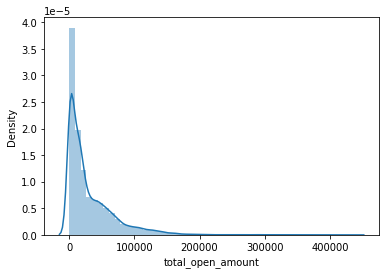

In [17]:
#Lets Analyze Total open amount variable
print(X_train.total_open_amount.skew())
print(X_train.total_open_amount.kurtosis())
sns.distplot(X_train['total_open_amount'])

It is showing high positive skew and highly Leptokurtic. Lets fix that

-0.9292814167008404
0.4604870226993496


<AxesSubplot:xlabel='total_open_amount', ylabel='Density'>

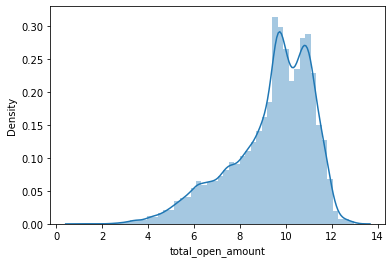

In [18]:
#Log transforming and observing results
normalised_open_amount = np.log(X_train.total_open_amount)
print(normalised_open_amount.skew())
print(normalised_open_amount.kurtosis())
sns.distplot(normalised_open_amount)

Now it is looking way better. Skew value and kurtosis value lie in an acceptable range. So we will log transform open amount of all X sets.


In [19]:
#Converting the values of total open amount of all the X_sets and adding 2 to remove negative values
X_train['total_open_amount'] = np.log(X_train['total_open_amount']) + 2
X_validation['total_open_amount'] = np.log(X_validation['total_open_amount']) + 2
X_test['total_open_amount'] = np.log(X_test['total_open_amount']) + 2

In [20]:
#Analyzing the covariances of columns and target
print(y_train.cov(X_train.total_open_amount))
print(X_train.total_open_amount.corr(y_train))

0.13147545572289307
0.006255468006694228


In [21]:
#Observing cust payment terms value counts
X_train.cust_payment_terms.value_counts()

NAA8    12057
NAH4     7940
CA10     2360
NAC6     1041
NAM4      830
NAAX      746
NAG2      614
NAU5      567
NAGD      556
NAD1      545
NAX2      449
NA32      420
NAM2      330
NA10      254
NAD5      240
NAVF      180
NAM1      163
NAVE      152
NAAW      136
NAWN      116
NAVR       97
NAVQ       80
NAUZ       58
NAWP       38
NACB       32
NA3B       28
NAVM       28
CA30       23
NA38       15
NABG       15
NAVL       15
NAB1       14
NA9X       12
C106       11
BR56       10
NAWU        9
NA84        9
NAD4        9
NA3F        9
NAUP        5
NA25        5
NAM3        5
NAVD        5
NATU        4
NATM        4
NA31        4
BR12        3
NATH        3
NAUX        2
NAVC        2
NATL        2
NANC        2
NAV2        2
NAD8        1
NAUI        1
CAB1        1
B030        1
NATJ        1
Name: cust_payment_terms, dtype: int64

NAA8 and NAH4 have high occurences. Rest of the catergories not so much. Rest can be binned in an 'OTHERS' category.

In [22]:
#Observing Buisness code
X_train.business_code.value_counts()

U001    27328
CA02     2424
U013      411
U002       89
U005        8
U007        1
Name: business_code, dtype: int64

U001 has very high occurences. Rest of the categories not so much. Rest can be binned in an 'OTHERS' category.

In [23]:
#Observing doc type
X_train['document type'].value_counts()

RV    30255
X2        6
Name: document type, dtype: int64

This should be dropped because frequency of one category out of the two is very low. Pointless feature

### **FEATURE ENGINEERING**

In [24]:
#Dropping these columns because they are useless features in my opinion
X_train.drop(columns=['cust_number','name_customer','clear_date', 'buisness_year', 'posting_date', 'document_create_date.1', 'document type', 'baseline_create_date'], axis = 1, inplace = True)
X_validation.drop(columns=['cust_number','name_customer','clear_date', 'buisness_year', 'posting_date', 'document_create_date.1', 'document type', 'baseline_create_date'], axis = 1, inplace = True)
X_test.drop(columns=['cust_number','name_customer','clear_date', 'buisness_year', 'posting_date', 'document_create_date.1', 'document type', 'baseline_create_date'], axis = 1, inplace = True)

Now, we need to encode the categorical column Cust payment terms.

We will use frequency encoding. Replace the categories with their respective frequency divided by total sum of all categories.

We will create 3 categories namely NAA8, NAH4 and others(all except NAA8 and NAH4)

In [25]:
#Finding the cust payment terms frequency by sum values
X_train.cust_payment_terms.value_counts()/X_train.cust_payment_terms.value_counts().sum()

NAA8    0.398434
NAH4    0.262384
CA10    0.077988
NAC6    0.034401
NAM4    0.027428
NAAX    0.024652
NAG2    0.020290
NAU5    0.018737
NAGD    0.018373
NAD1    0.018010
NAX2    0.014838
NA32    0.013879
NAM2    0.010905
NA10    0.008394
NAD5    0.007931
NAVF    0.005948
NAM1    0.005386
NAVE    0.005023
NAAW    0.004494
NAWN    0.003833
NAVR    0.003205
NAVQ    0.002644
NAUZ    0.001917
NAWP    0.001256
NACB    0.001057
NA3B    0.000925
NAVM    0.000925
CA30    0.000760
NA38    0.000496
NABG    0.000496
NAVL    0.000496
NAB1    0.000463
NA9X    0.000397
C106    0.000364
BR56    0.000330
NAWU    0.000297
NA84    0.000297
NAD4    0.000297
NA3F    0.000297
NAUP    0.000165
NA25    0.000165
NAM3    0.000165
NAVD    0.000165
NATU    0.000132
NATM    0.000132
NA31    0.000132
BR12    0.000099
NATH    0.000099
NAUX    0.000066
NAVC    0.000066
NATL    0.000066
NANC    0.000066
NAV2    0.000066
NAD8    0.000033
NAUI    0.000033
CAB1    0.000033
B030    0.000033
NATJ    0.000033
Name: cust_pay

In [26]:
#Finding frequency by sum value for NAA8 
(X_train.cust_payment_terms.value_counts()/X_train.cust_payment_terms.value_counts().sum()).iloc[:1].sum()

0.39843362744126104

In [27]:
#Finding frequency by sum value for NAH4
(X_train.cust_payment_terms.value_counts()/X_train.cust_payment_terms.value_counts().sum()).iloc[1:2].sum()

0.2623839265060639

In [28]:
#Finding frequency by sum value for 'others' category(not including NAA8 and NAH4) 
(X_train.cust_payment_terms.value_counts()/X_train.cust_payment_terms.value_counts().sum()).iloc[2:].sum()

0.3391824460526751

We will first encode these categories with a number(1:NAA8, 2:NAH4, 3:OTHERS)
and then encode it with these values below

cust_payment_terms encoder details
1.   NAA8 = 1(0.4)
2.   NAH4 = 2(0.26)
3.   OTHERS = 3(0.34)



In [29]:
#Creating the cust_payment_terms encoder
cust_payment_terms_encoder = {}
cust_payment_terms_encoder[1], cust_payment_terms_encoder[2], cust_payment_terms_encoder[3] = 0.4, 0.26, 0.34
cust_payment_terms_encoder

{1: 0.4, 2: 0.26, 3: 0.34}

In [30]:
#Encoding cust_payment_terms first with a number (1,2,3) and then mapping it with our dictionary
X_train = X_train.assign(cust_payment_terms = np.where(np.logical_or(X_train.cust_payment_terms=='NAA8', X_train.cust_payment_terms=='NAH4'), X_train.cust_payment_terms, 3))
X_train = X_train.assign(cust_payment_terms = np.where(X_train.cust_payment_terms == 'NAH4', 2, X_train.cust_payment_terms))
X_train = X_train.assign(cust_payment_terms = np.where(X_train.cust_payment_terms == 'NAA8', 1, X_train.cust_payment_terms))
X_train.cust_payment_terms = X_train.cust_payment_terms.map(cust_payment_terms_encoder) 

In [31]:
#Doing the same change for X_test
X_test = X_test.assign(cust_payment_terms = np.where(np.logical_or(X_test.cust_payment_terms=='NAA8', X_test.cust_payment_terms=='NAH4'), X_test.cust_payment_terms, 3))
X_test = X_test.assign(cust_payment_terms = np.where(X_test.cust_payment_terms == 'NAH4', 2, X_test.cust_payment_terms))
X_test = X_test.assign(cust_payment_terms = np.where(X_test.cust_payment_terms == 'NAA8', 1, X_test.cust_payment_terms))
X_test.cust_payment_terms = X_test.cust_payment_terms.map(cust_payment_terms_encoder) 

In [32]:
#Doing the same change for X_validation
X_validation = X_validation.assign(cust_payment_terms = np.where(np.logical_or(X_validation.cust_payment_terms=='NAA8', X_validation.cust_payment_terms=='NAH4'), X_validation.cust_payment_terms, 3))
X_validation = X_validation.assign(cust_payment_terms = np.where(X_validation.cust_payment_terms == 'NAH4', 2, X_validation.cust_payment_terms))
X_validation = X_validation.assign(cust_payment_terms = np.where(X_validation.cust_payment_terms == 'NAA8', 1, X_validation.cust_payment_terms))
X_validation.cust_payment_terms = X_validation.cust_payment_terms.map(cust_payment_terms_encoder) 

In [33]:
#LabelEncoding invoice currency. (Only two categories, so labelencoding will make categories binary)
from sklearn.preprocessing import LabelEncoder
invoice_currency_encoder = LabelEncoder()
X_train['invoice_currency'] = invoice_currency_encoder.fit_transform(X_train['invoice_currency'])
X_validation['invoice_currency'] = invoice_currency_encoder.fit_transform(X_validation['invoice_currency'])
X_test['invoice_currency'] = invoice_currency_encoder.transform(X_test['invoice_currency'])

In [34]:
#Creating the Features
X_train['due_month'] = pd.DatetimeIndex(X_train['due_in_date']).month #Month of the due date
X_train['due_weekday'] = X_train.due_in_date.dt.weekday #WeekDay of the due date
X_train['due_week'] = X_train.due_in_date.dt.day//7 #Week of the month in due date
X_train['isweekend'] = X_train.assign(Isweekend = np.where(np.logical_or(X_train.due_in_date.dt.weekday==5, X_train.due_in_date.dt.weekday==6), 1, 0)).Isweekend  #Weekends are encoded with 1 and not weekends 0
X_train['business_code'] = X_train.assign(business_code = np.where(X_train.business_code == 'U001', 0, 1)).business_code #Encoding U001 with 0 and the rest with 1 as decided in the EDA phase.
X_train.drop(columns=['due_in_date'], axis = 1, inplace = True) #Removing the Due date column from X_train

In [35]:
#Doing the same for X_test
X_test['due_month'] = pd.DatetimeIndex(X_test['due_in_date']).month
X_test['due_weekday'] = X_test.due_in_date.dt.weekday
X_test['due_week'] = X_test.due_in_date.dt.day//7
X_test['isweekend'] = X_test.assign(Isweekend = np.where(np.logical_or(X_test.due_in_date.dt.weekday==5, X_test.due_in_date.dt.weekday==6), 1, 0)).Isweekend
X_test['business_code'] = X_test.assign(business_code = np.where(X_test.business_code == 'U001', 0, 1)).business_code
X_test.drop(columns=['due_in_date'], axis = 1, inplace = True)

In [36]:
#Doing the same for X_validation
X_validation['due_month'] = pd.DatetimeIndex(X_validation['due_in_date']).month
X_validation['due_weekday'] = X_validation.due_in_date.dt.weekday
X_validation['due_week'] = X_validation.due_in_date.dt.day//7
X_validation['isweekend'] = X_validation.assign(Isweekend = np.where(np.logical_or(X_validation.due_in_date.dt.weekday==5, X_validation.due_in_date.dt.weekday==6), 1, 0)).Isweekend
X_validation['business_code'] = X_validation.assign(business_code = np.where(X_validation.business_code == 'U001', 0, 1)).business_code
X_validation.drop(columns=['due_in_date'], axis = 1, inplace = True)

### **FEATURE SELECTION**

In [37]:
#Observing all the correlation of features with the target variable
print(f'Due month          {X_train.due_month.corr(y_train)}')
print(f'Total open amount  {X_train.total_open_amount.corr(y_train)}')
print(f'Due weekday        {X_train.due_weekday.corr(y_train)}')
print(f'Due week           {X_train.due_week.corr(y_train)}')
print(f'Invoice currency   {X_train.invoice_currency.corr(y_train)}')
print(f'Buisness Code      {X_train.business_code.corr(y_train)}')
print(f'Cust payment terms {X_train.cust_payment_terms.corr(y_train)}')
print(f'Is weekend         {X_train.isweekend.corr(y_train)}')

Due month          -0.03398162809808844
Total open amount  0.006255468006694228
Due weekday        0.013752411508583714
Due week           -0.002477712636908808
Invoice currency   -0.12819122062576774
Buisness Code      0.15599693744557216
Cust payment terms 0.10095041644475669
Is weekend         0.013976448763670804


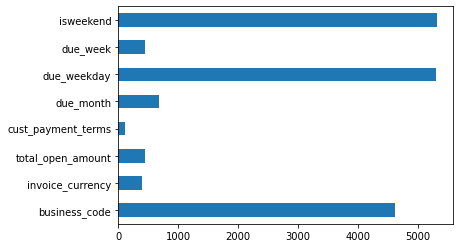

In [38]:
#Using chi2 for observing features
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

bestfeatures = SelectKBest(score_func=chi2, k=8)
fit = bestfeatures.fit(X_train, y_train)
Featurescores = pd.Series(fit.scores_, index=X_train.columns)
Featurescores
Featurescores.plot(kind = 'barh')
plt.show()

The values shown here is pretty dicey. But it is what it is. Lets try another feature selection technique

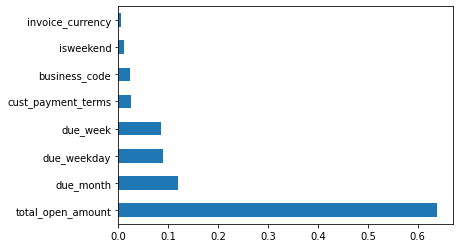

In [39]:
#Using RandomForestRegressor for observing features
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(criterion='mse', n_estimators=200)
model.fit(X_train,y_train)
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(8).plot(kind='barh')
plt.show()

This looks nice !

Observing the plots, all features except invoice currency, business code and isweekend are good. We will consider the remaining 5 features(cust_payment_terms, due_week, due_weekday, due_month, total_open_amount) for model training

In [40]:
#Discarding useless features
X_train.drop(columns=['invoice_currency', 'isweekend', 'business_code'], axis = 1, inplace = True)
X_test.drop(columns=['invoice_currency', 'isweekend', 'business_code'], axis = 1, inplace = True)
X_validation.drop(columns=['invoice_currency', 'isweekend', 'business_code'], axis = 1, inplace = True)

### **MODEL TRAINING**

In [41]:
#Training the model on the RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(random_state=0)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

In [42]:
#Creating predictions of train and validation sets
y_pred_train = model.predict(X_train)
y_pred_validation = model.predict(X_validation)

In [43]:
#Finding the root mean square error of train and validation sets
from sklearn.metrics import mean_squared_error
train_rmse = mean_squared_error(y_train, y_pred_train)**0.5
validation_rmse = mean_squared_error(y_validation, y_pred_validation)**0.5
print(f'Train {train_rmse}')
print(f'Validation {validation_rmse}')

Train 4.491342870418137
Validation 14.093246556670975


This shows the root mean square error in delay between actual and predicted

In [44]:
#Function returning aging buckets

'''This function categorizes the delay into age buckets and returns an array containing those age buckets'''

def age_bucketer(y):
  age_bucket = [0]*y.shape[0]
  for i, j in enumerate(y):
    if round(j)<16:
      age_bucket[i] = 1
      continue
    if round(j) >= 16 and round(j)<31:
      age_bucket[i] = 2
      continue
    if round(j) >= 31 and round(j)<46:
      age_bucket[i] = 3
      continue
    if round(j) >= 46 and round(j)<60:
      age_bucket[i] = 4
      continue
    else:
      age_bucket[i] = 5
      continue

  return age_bucket  

In [45]:
#Testing Aging Bucket Accuracy

'''So, we are subtracting actual and predicted columns. After subtraction, Values having 0 means, it is correctly predicted. 
Anything other than 0 means wrong prediction.
So, we are obtaining the 0th index(values containing 0) of the array returned by value_counts on subtraction and dividing it by
the shape[0] of y array which basically is the length y. This gives us the accuracy'''

aging_bucket_actual = age_bucketer(y_train)
aging_bucket_pred = age_bucketer(y_pred_train)
print(f'Train {(pd.Series(aging_bucket_actual)-pd.Series(aging_bucket_pred)).value_counts()[0]/pd.Series(aging_bucket_actual).shape[0]}')

aging_bucket_actual = age_bucketer(y_validation)
aging_bucket_pred = age_bucketer(y_pred_validation)
print(f'Validation {(pd.Series(aging_bucket_actual)-pd.Series(aging_bucket_pred)).value_counts()[0]/pd.Series(aging_bucket_actual).shape[0]}')

Train 0.9690690988400912
Validation 0.9288594934666882


Well these are good numbers. Lets try to reach a better accuracy with hyperparameter tuning

### **HYPERPARAMETER TUNING**

In [46]:
#Importing grid seach cross validation 
from sklearn.model_selection import GridSearchCV

In [47]:
#Making a matrix of hyperparameters
parameters = [{'n_estimators': [10, 50, 75, 100],
               'max_depth': [1,2,4,5],
               'min_samples_leaf': [1, 2],
               'max_leaf_nodes': [1, 2]}]

parameters

[{'n_estimators': [10, 50, 75, 100],
  'max_depth': [1, 2, 4, 5],
  'min_samples_leaf': [1, 2],
  'max_leaf_nodes': [1, 2]}]

In [48]:
#Fitting grid search CV with the validation set
grid_search = GridSearchCV(estimator=model, param_grid=parameters, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search = grid_search.fit(X_validation, y_validation)

In [49]:
#Finding the best mse(mean square error) score
abs(grid_search.best_score_)

68.68138457261108

In [50]:
#Finding the best hyperparameters
grid_search.best_params_

{'max_depth': 1,
 'max_leaf_nodes': 2,
 'min_samples_leaf': 1,
 'n_estimators': 10}

### **RETRAINING MODEL WITH NEW HYPERPARAMETERS**



In [51]:
#Training the model on the RandomForestRegressor with new hyperparameters
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=10, max_depth = 1, max_leaf_nodes=2, min_samples_leaf=1, random_state = 0)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=1, max_leaf_nodes=2, n_estimators=10,
                      random_state=0)

In [52]:
#Storing predictions of train and validation set
y_pred_train = model.predict(X_train)
y_pred_validation = model.predict(X_validation)

In [53]:
#Finding the root mean square error of train and validation set
from sklearn.metrics import mean_squared_error
train_rmse = mean_squared_error(y_train, y_pred_train)**0.5
validation_rmse = mean_squared_error(y_validation, y_pred_validation)**0.5
print(f'Train {train_rmse}')
print(f'Validation {validation_rmse}')

Train 11.65249723449655
Validation 8.26657341595179


As we can see, rmse on the validation set has decreased which means our model is giving better predictions

In [54]:
#Observing Aging Bucket Accuracy
aging_bucket_actual = age_bucketer(y_train)
aging_bucket_pred = age_bucketer(y_pred_train)
print(f'Train {(pd.Series(aging_bucket_actual)-pd.Series(aging_bucket_pred)).value_counts()[0]/pd.Series(aging_bucket_actual).shape[0]}')

aging_bucket_actual = age_bucketer(y_validation)
aging_bucket_pred = age_bucketer(y_pred_validation)
print(f'Validation {(pd.Series(aging_bucket_actual)-pd.Series(aging_bucket_pred)).value_counts()[0]/pd.Series(aging_bucket_actual).shape[0]}')

Train 0.9596510359869138
Validation 0.9658009356347798


The aging bucket accuracy has also increased in the validation set

As our model performance has increased using these new hyperparameters, we will consider these hyperparameters

### **PREDICTION ON TEST SET**

In [55]:
#Storing the predictions in an array
y_pred = model.predict(X_test)

In [56]:
#Finding root mean square error of test set
test_rmse = mean_squared_error(y_test, y_pred)**0.5
print(f'Test set rmse {test_rmse}')

Test set rmse 8.986725714672428


In [57]:
#Observing aging bucket accuracy (rounding off the percentage)
aging_bucket_actual = age_bucketer(y_test)
aging_bucket_pred = age_bucketer(y_pred)
print(f'Test Set accuracy {round(((pd.Series(aging_bucket_actual)-pd.Series(aging_bucket_pred)).value_counts()[0]/pd.Series(aging_bucket_actual).shape[0])*100, 2)}%')

Test Set accuracy 97.39%


### **PREDICTING RANDOM RESULTS FROM TEST SET**

Run this cell for a random prediction comparison.

Note: These predictions are from the test set

In [58]:
import random
from datetime import timedelta
n = random.randint(0, len(y_pred)-1) #n is a random number in the range of the length of y_test
NUM = len(y)+n  #NUM is the index of the row in the dataset df

print(f'Actual    : {list(df.clear_date.dt.date)[NUM]}, Category = {aging_bucket_actual[n]}')
print(f'Predicted : {df.due_in_date.dt.date[NUM] + timedelta(days = round(list(y_pred)[n]))}, Category = {aging_bucket_pred[n]}')


Actual    : 2020-01-22, Category = 1
Predicted : 2020-01-25, Category = 1


## **PREDICTING MISSING PAYMENT DATES**

We have two dataframes, X_missing and missing_clear_date. We will convert X_missing into a featureset and predict its values and store it in an array. Then we will add the prediction columns and age bucket category columns in missing_clear_date dataframe.

In [59]:
#Converting X_missing in an X_train format.
X_missing.drop(columns=['cust_number', 'name_customer', 'buisness_year', 'posting_date', 'document_create_date.1', 'invoice_currency', 'document type', 'baseline_create_date', 'business_code', 'clear_date'], axis = 1, inplace = True)
X_missing['due_in_date'] = pd.to_datetime(X_missing['due_in_date'], format = '%Y%m%d')
X_missing['total_open_amount'] = np.log(X_missing['total_open_amount']) + 2
X_missing = X_missing.assign(cust_payment_terms = np.where(np.logical_or(X_missing.cust_payment_terms=='NAA8', X_missing.cust_payment_terms=='NAH4'), X_missing.cust_payment_terms, 3))
X_missing = X_missing.assign(cust_payment_terms = np.where(X_missing.cust_payment_terms == 'NAH4', 2, X_missing.cust_payment_terms))
X_missing = X_missing.assign(cust_payment_terms = np.where(X_missing.cust_payment_terms == 'NAA8', 1, X_missing.cust_payment_terms))
X_missing.cust_payment_terms = X_missing.cust_payment_terms.map(cust_payment_terms_encoder) 
X_missing['due_month'] = pd.DatetimeIndex(X_missing['due_in_date']).month 
X_missing['due_weekday'] = X_missing.due_in_date.dt.weekday 
X_missing['due_week'] = X_missing.due_in_date.dt.day//7
X_missing.drop(columns=['due_in_date'], axis = 1, inplace = True)

In [60]:
#Storing predictions of X_missing in an array astype int
y_missing = model.predict(X_missing)
y_missing = y_missing.round().astype(int)

In [61]:
#Typecasting due_in_date column of missing_clear_date into datetime.
missing_clear_date['due_in_date'] = pd.to_datetime(missing_clear_date['due_in_date'], format = '%Y%m%d')

In [62]:
#Storing predicted clear Date by adding our predicted delay and due date and storing it in an array.
predicted = []
for i in range(len(y_missing)):
  predicted.append(list(missing_clear_date.due_in_date)[i]+timedelta(days=int(y_missing[i])))

In [63]:
#Adding Predicted clear date column in our dataframe missing_clear_date with predicted date values
missing_clear_date['Predicted clear date'] = predicted

In [64]:
#Creating aging bucket based on delay
age_bucket_missing = age_bucketer(y_missing)

In [65]:
#Adding the column Age Bucket in our dataframe which holds the values of the age buckets
missing_clear_date['Age Bucket'] = age_bucket_missing

In [66]:
Age_dict = {1: '0-15 days',
            2: '16-30 days',
            3: '31-45 days',
            4: '45-60 days',
            5: 'More than 60 days'}

In [67]:
missing_clear_date['Age Bucket'] = missing_clear_date['Age Bucket'].map(Age_dict)

In [68]:
#Final Dataframe, as per our usecase
missing_clear_date

,business_code,cust_number,name_customer,clear_date,buisness_year,posting_date,document_create_date.1,due_in_date,invoice_currency,document type,total_open_amount,baseline_create_date,cust_payment_terms,Predicted clear date,Age Bucket
45576,U001,0200769623,WAL-MAR corp,NaN,2020.0,2020-04-02,20200402,2020-04-17,USD,RV,62935.24,20200402.0,NAH4,2020-04-15,0-15 days
45577,U001,0200126819,MCLANE trust,NaN,2020.0,2020-02-28,20200228,2020-03-14,USD,RV,26266.00,20200228.0,NAA8,2020-03-16,0-15 days
45578,U001,0200920735,ALBERT trust,NaN,2020.0,2020-03-31,20200331,2020-04-15,USD,RV,72251.82,20200331.0,NAA8,2020-04-17,0-15 days
45579,U001,0200769623,WAL-MAR us,NaN,2020.0,2020-03-23,20200323,2020-04-07,USD,RV,2373.96,20200323.0,NAH4,2020-04-05,0-15 days
45580,U001,0200749225,SUPER associates,NaN,2020.0,2020-04-27,20200427,2020-05-12,USD,RV,66844.80,20200427.0,NAA8,2020-05-14,0-15 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,U001,0200794332,COST associates,NaN,2020.0,2020-03-25,20200325,2020-04-09,USD,RV,10094.26,20200325.0,NAAX,2020-04-11,0-15 days
49996,U001,0200769623,WAL-MAR llc,NaN,2020.0,2020-04-23,20200423,2020-05-08,USD,RV,183.85,20200423.0,NAH4,2020-05-06,0-15 days
49997,U001,0200726979,BJ'S foundation,NaN,2020.0,2020-05-04,20200504,2020-05-19,USD,RV,139.26,20200504.0,NAA8,2020-05-21,0-15 days
49998,U001,0200769623,WAL-MAR llc,NaN,2020.0,2020-04-28,20200428,2020-05-13,USD,RV,5752.50,20200428.0,NAH4,2020-05-11,0-15 days
